In [1]:
import nibabel as nib
import zarr
import numpy as np
import SimpleITK as sitk

def get_numpy_from_nifti(nifti_file):
    nifti_img = nib.load(nifti_file)
    nifti_data = nifti_img.get_fdata()
    return nifti_data

def get_data_from_nrrd(nrrd_file):
    image = sitk.ReadImage(nrrd_file)
    data = sitk.GetArrayFromImage(image).astype(np.uint8)
    return data

# def convert_nifti_to_zarr(nifti_file, zarr_output):
#     nifti_img = nib.load(nifti_file)
#     nifti_data = nifti_img.get_fdata()
#     print("Nifti data: ", nifti_data.dtype)

#     affine = nifti_img.affine
#     header = nifti_img.header
#     print(affine,header)

#     data = nifti_data.astype(np.float32)
#     print(data.shape)

#     zarr.save(zarr_output, data)

    # # To store additional metadata like affine or header:
    # zarr_grp = zarr.open_group(zarr_output, mode='a')
    # zarr_grp.create_dataset('affine', data=affine)
    # zarr_grp.create_dataset('header', data=header.structarr)



In [2]:
image_data = get_numpy_from_nifti(nifti_file="/data/693196.nii.gz")
mask_data = get_data_from_nrrd(nrrd_file="/data/693196-VS_73_sasha_smoothed.nii.gz.seg.nrrd").astype(np.uint8)

min_val = np.min(image_data)
max_val = np.max(image_data)

norm_image = (image_data - min_val) / (max_val - min_val)

scaled_image = (norm_image * 255).astype(np.float16)

print(scaled_image.shape, mask_data.shape)

(929, 1282, 458) (458, 1282, 929)


In [3]:
def rearrange_axis(array1, array2):
    array1_shape = array1.shape
    array2_shape = array2.shape
    
    # Create a mapping from shape to axis index
    shape_to_axis = {array1_shape[i]: i for i in range(len(array1_shape))}
    
    # Generate the new axis order based on array2's shape
    new_axis_order = [shape_to_axis[dim] for dim in array2_shape]
    
    # Reorder array1 to match the shape of array2
    array1 = np.transpose(array1, new_axis_order)
    return array1

scaled_image = rearrange_axis(scaled_image, mask_data)
print(scaled_image.shape, mask_data.shape)

(458, 1282, 929) (458, 1282, 929)


In [6]:
print(scaled_image.min(), scaled_image.max(), scaled_image.dtype)
print(mask_data.min(), mask_data.max(), mask_data.dtype)

0.0 255.0 float16
0 1 uint8


In [5]:
def write_numpy_to_zarr(data, zarr_output):
    zarr.save(zarr_output, data)

In [7]:
write_numpy_to_zarr(scaled_image, "/scratch/scaled_693196.zarr")
write_numpy_to_zarr(mask_data, "/scratch/693196-VS_73_sasha_smoothed.zarr")

In [8]:
loaded_zarr = zarr.load("/scratch/scaled_693196.zarr")
loaded_mask = zarr.load("/scratch/693196-VS_73_sasha_smoothed.zarr")

In [9]:
print(loaded_zarr.min(), loaded_zarr.max(), loaded_zarr.dtype)
print(loaded_mask.min(), loaded_mask.max(), loaded_mask.dtype)

0.0 255.0 float16
0 1 uint8


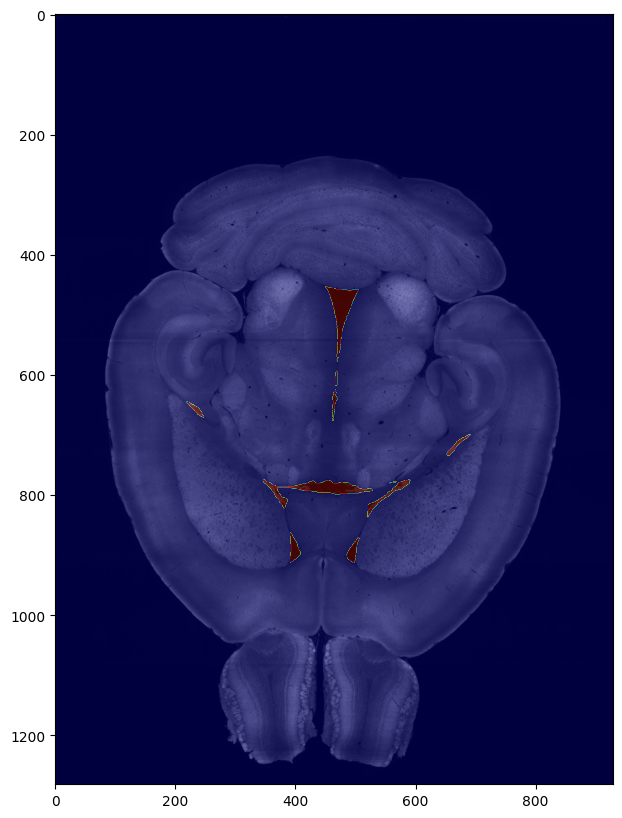

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

index = 200
plt.figure(figsize=(10,10))
plt.imshow(loaded_zarr[index, ...], cmap="gray")
plt.imshow(loaded_mask[index, ...], alpha=0.5, cmap="jet")
plt.show()